In [ ]:
#Only with imagettes generates by the best models

In [13]:
#D'abord vérifier si on a du Lenet

In [25]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import time
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model, preprocessing 
from keras.applications.imagenet_utils import preprocess_input
from sklearn import metrics
%matplotlib inline


In [26]:


def dictionnaire_conversion():
    dic_labels_to_num={}
    dic_num_to_labels={}

    dic_labels_to_num["autre"]=0
    dic_labels_to_num["chevreuil"]=1
    dic_labels_to_num["corneille"]=2
    dic_labels_to_num["faisan"]=3
    dic_labels_to_num["lapin"]=4
    dic_labels_to_num["pigeon"]=5
    dic_labels_to_num["oiseau"]=6
    
    dic_num_to_labels[0]="autre"
    dic_num_to_labels[1]="chevreuil"
    dic_num_to_labels[2]="corneille"
    dic_num_to_labels[3]="faisan"
    dic_num_to_labels[4]="lapin"
    dic_num_to_labels[5]="pigeon"
    dic_num_to_labels[6]="oiseau"
    
    return dic_labels_to_num,dic_num_to_labels




def build_model(width, height, depth, classes):
	# initialize the input shape and channels dimension to be
	# "channels last" ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# build the model using Keras' Sequential API
	model = Sequential([
		# CONV => RELU => BN => POOL layer set
		Conv2D(16, (3, 3), padding="same", input_shape=inputShape),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 2 => POOL layer set
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(32, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# (CONV => RELU => BN) * 3 => POOL layer set
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		Conv2D(64, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
		# first (and only) set of FC => RELU layers
		Flatten(),
		Dense(256),
		Activation("relu"),
		BatchNormalization(),
		Dropout(0.5),
		# softmax classifier
		Dense(classes),
		Activation("softmax")
	])
	# return the built model to the calling function
	return model

In [27]:
#Essayons de faire lenet avec tf voir ci-dessous . Il y a aussi une commande pour voir le résumer peut être .resume
def build_model(width, height, depth, classes,drop_out_rate):
	# initialize the input shape and channels dimension to be
	# "channels last" ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# build the model using Keras' Sequential API
	model = Sequential([
		# CONV => RELU => BN => POOL layer set
		Conv2D(30, (5, 5), padding="same", input_shape=inputShape),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
        
		# (CONV => RELU => BN) * 2 => POOL layer set
		Conv2D(16, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),

        
		# first (and only) set of FC => RELU layers
		Flatten(),
		Dense(128),
		Activation("relu"),
		BatchNormalization(),
		Dropout(drop_out_rate),
        
		# softmax classifier
		Dense(classes),
		Activation("softmax")
	])
	# return the built model to the calling function
	return model

In [28]:
#Paramètres

#generateur_path='/mnt/VegaSlowDataDisk/c3po/Chaine_de_traitement/Train_imagettes_annotées/type_oiseau/Materiel/generateur.csv'
test_size=0.2
epochs=200
batch_size = 600
zoom_range = 1.25
horizontal_flip = True
Minimum_Number_Class=100
dropout_rate=0.3
#steps_per_epoch=len(data_train)//batch_size
steps_per_epoch=1
#validation_steps=len(data_test)//batch_size
validation_steps=1


In [29]:

base_img_paths="/home/marcpozzo/Desktop/c3po/Images_aquises/"
generateur_path='/mnt/VegaSlowDataDisk/c3po/Images_aquises/generateur_bigger.csv'

df=pd.read_csv(generateur_path)
df.drop('labels',inplace=True,axis=1)

df["class"].unique()
for c in df:
    print(''+c+':',len(df[c].unique()))
df["class"].unique()


All_Unique=df["class"].unique()
Utilisable=[]
for i in df["class"].unique():
    if df["class"][df["class"]==i].count()>Minimum_Number_Class:
        Utilisable.append(i)
Utilisable
Non_Utilisable=set(All_Unique)-set(Utilisable)
Non_Utilisable
for i in Non_Utilisable:
    df=df[df["class"]!=i]
df=df[df["class"]!="oiseau"]  
df["class"].unique()


for i in range(len(df["class"])):
    image_name=df["img_paths"].iloc[i]
    df["img_paths"].iloc[i]=os.path.join(base_img_paths,image_name)
    

class: 13
img_paths: 6220


In [30]:
dic_labels_to_num,dic_num_to_labels=dictionnaire_conversion()

n_path="/mnt/VegaSlowDataDisk/c3po/Annotation_automatique/"
gen_imagettes=pd.read_csv(n_path+"fp+an_gen_tf.csv")

folder_imagettes="tf_200ep/"

liste_img_paths=[]
for i in range(len(gen_imagettes)):
    liste_img_paths.append(n_path+folder_imagettes+gen_imagettes["imagetteName"].iloc[i])

gen_imagettes["img_paths"]=liste_img_paths
gen_imagettes.head()

gen_imagettes["class"]="autre"

for i in range(len(gen_imagettes)):
    if gen_imagettes["IsFP"].iloc[i]==0:
        gen_imagettes["class"].iloc[i]=dic_num_to_labels[gen_imagettes["reel_classe"].iloc[i]]
    
gen_imagettes.head()  

/home/marcpozzo/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,path,filename,imagetteName,max_cat,predict_cat,xmin,xmax,ymin,ymax,former_index,IsFP,reel_classe,img_paths,class
0,./DonneesPI/timeLapsePhotos_Pi1_0,image_2019-04-30_18-17-30.jpg,image_2019-04-30_18-17-30_356_51_5.jpg,0.513831,5.0,509,518,290,298,356.0,1,0,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,autre
1,./DonneesPI/timeLapsePhotos_Pi1_0,image_2019-04-30_18-17-30.jpg,image_2019-04-30_18-17-30_295_91_5.jpg,0.914196,5.0,992,1014,321,339,295.0,1,0,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,autre
2,./DonneesPI/timeLapsePhotos_Pi1_0,image_2019-04-30_18-17-30.jpg,image_2019-04-30_18-17-30_296_93_2.jpg,0.932135,2.0,1197,1211,319,333,296.0,0,2,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,corneille
3,./DonneesPI/timeLapsePhotos_Pi1_0,image_2019-04-30_18-17-47.jpg,image_2019-04-30_18-17-47_689_74_5.jpg,0.742045,5.0,982,987,334,339,689.0,1,0,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,autre
4,./DonneesPI/timeLapsePhotos_Pi1_0,image_2019-04-30_18-17-47.jpg,image_2019-04-30_18-17-47_683_73_5.jpg,0.725646,5.0,853,867,339,356,683.0,1,0,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,autre


In [31]:
to_drop=['path', 'filename', 'imagetteName', 'max_cat', 'max_cat', 'xmin', 'xmax','ymin', 'ymax', 'former_index','reel_classe','IsFP','predict_cat']
gen_imagettes.drop(to_drop,inplace=True,axis=1)
gen_imagettes.head()

,img_paths,class
0,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,autre
1,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,autre
2,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,corneille
3,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,autre
4,/mnt/VegaSlowDataDisk/c3po/Annotation_automati...,autre


In [32]:
#gen_imagettes.drop("predict_cat",inplace=True,axis=1)
df=pd.concat([df,gen_imagettes])

/home/marcpozzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [33]:
df=df[df["class"]!="oiseau"]

In [34]:
df["class"].unique()

array(['autre', 'corneille', 'pigeon', 'chevreuil', 'lapin', 'faisan'],
      dtype=object)

In [11]:
from numpy.random import seed
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
seed(1)
tf.random.set_seed(2)

data_train,data_test= train_test_split(df,stratify=df["class"], test_size=test_size,random_state=42)
train_data_generator = ImageDataGenerator(
        preprocessing_function = preprocess_input
        # data augmentation
        #rotation_range = 10,
        #zoom_range = zoom_range,
        #horizontal_flip = horizontal_flip
        )

test_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
    #preprocessing_function = preprocess_input)




train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_train) )


test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_test))

gen=train_generator[0]

x_train=gen[0]
y_train=gen[1]



gen_test=test_generator[0]

x_test=gen_test[0]
y_test=gen_test[1]


Found 12444 validated image filenames belonging to 6 classes.
Found 3112 validated image filenames belonging to 6 classes.


In [43]:
x_reshape=x_test.reshape((-1, 28, 28, 6))
print(x_reshape.shape)
y_reshape=y_train[:1556]
model=build_model(28, 28, 6, 6,0.2)
model.compile(loss='sparse_categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme de descente de gradient
              metrics=['accuracy'])        
model.fit(x_reshape,y_reshape,epochs=5,verbose=0)

(1556, 28, 28, 6)


In [ ]:
#First test the influence of number of epochs on the other recall

In [18]:
import cv2
cv2.cvtColor(x_test[0], cv2.COLOR_RGB2HSV)

array([[[175.89209   ,   5.9252586 ,   2.2210007 ],
        [175.89209   ,   3.117745  ,   4.2210007 ],
        [167.70763   ,   1.7224185 ,   8.221001  ],
        ...,
        [147.55655   ,   2.7918572 ,   7.2210007 ],
        [147.55655   ,   2.7918572 ,   7.2210007 ],
        [147.55655   ,   2.7918572 ,   7.2210007 ]],

       [[175.89209   ,   3.117745  ,   4.2210007 ],
        [175.89209   ,   2.5205903 ,   5.2210007 ],
        [175.89209   ,   1.8224626 ,   7.2210007 ],
        ...,
        [147.55655   ,   2.4522567 ,   8.221001  ],
        [147.55655   ,   2.4522567 ,   8.221001  ],
        [147.55655   ,   2.4522567 ,   8.221001  ]],

       [[175.89209   ,   2.1154158 ,   6.2210007 ],
        [175.89209   ,   1.8224626 ,   7.2210007 ],
        [175.89209   ,   1.4271774 ,   9.221001  ],
        ...,
        [147.28745   ,   2.5148873 ,   7.2210007 ],
        [147.28745   ,   1.9694179 ,   9.221001  ],
        [147.28745   ,   1.9694179 ,   9.221001  ]],

       ...,

      

In [90]:
history=model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))
#model.save("tf_match_100ep")

              precision    recall  f1-score   support

           0    0.97603   0.94593   0.96074      2238
           1    0.80392   0.89130   0.84536        46
           2    0.89216   0.89655   0.89435       406
           3    0.80469   0.91964   0.85833       112
           4    0.46269   0.72093   0.56364        43
           5    0.86851   0.94007   0.90288       267

    accuracy                        0.93413      3112
   macro avg    0.80133   0.88574   0.83755      3112
weighted avg    0.94006   0.93413   0.93624      3112



In [92]:
history=model.fit(x_train,y_train,epochs=200,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))
#model.save("tf_match_300ep")

              precision    recall  f1-score   support

           0    0.98202   0.94081   0.96097      2264
           1    0.74510   0.92683   0.82609        41
           2    0.87255   0.91282   0.89223       390
           3    0.72656   0.95876   0.82667        97
           4    0.56716   0.70370   0.62810        54
           5    0.87543   0.95113   0.91171       266

    accuracy                        0.93445      3112
   macro avg    0.79480   0.89901   0.84096      3112
weighted avg    0.94091   0.93445   0.93641      3112

INFO:tensorflow:Assets written to: tf_match_200ep/assets


In [93]:
history=model.fit(x_train,y_train,epochs=200,validation_data=(x_test,y_test),verbose=0)
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))
#model.save("tf_match_800ep")

              precision    recall  f1-score   support

           0    0.98248   0.94334   0.96251      2259
           1    0.66667   0.89474   0.76404        38
           2    0.90686   0.88729   0.89697       417
           3    0.70312   0.96774   0.81448        93
           4    0.46269   0.81579   0.59048        38
           5    0.88235   0.95506   0.91727       267

    accuracy                        0.93541      3112
   macro avg    0.76736   0.91066   0.82429      3112
weighted avg    0.94521   0.93541   0.93846      3112

INFO:tensorflow:Assets written to: tf_match_500ep/assets


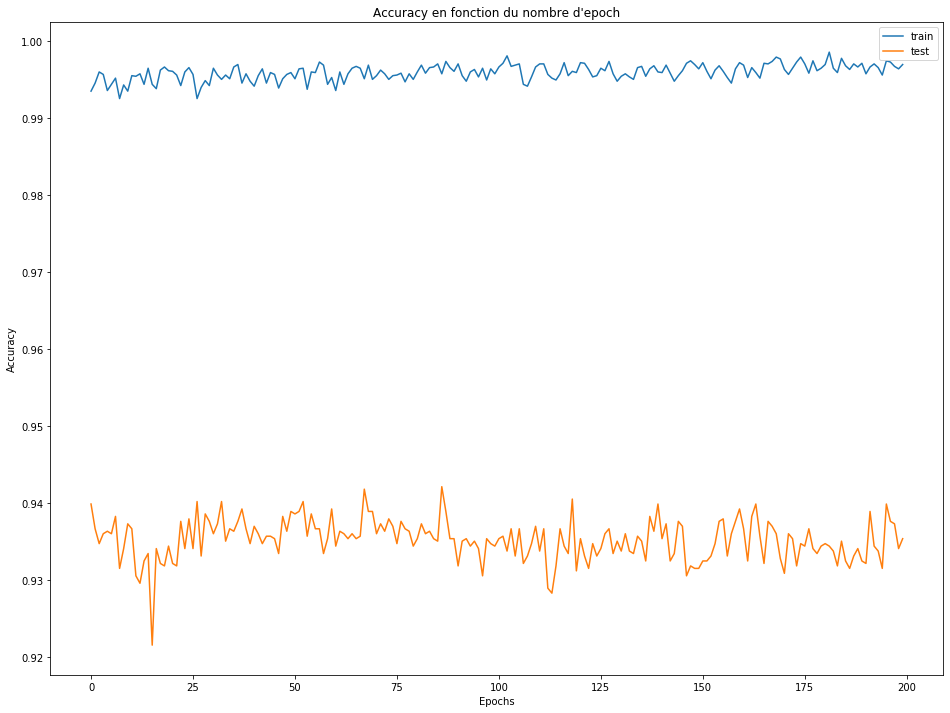

In [94]:
plt.figure(figsize=(16,12))

plt.plot(history.history['acc'],label="train");
plt.plot(history.history['val_acc'],label="test");
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy en fonction du nombre d'epoch");
plt.legend();